# Neural Networks ECE NTUA Course 2019-20 ~ Team M.B.4
## Lab Assingment #1: Classification - Study of UCI Datasets - Small (S05)

### A. The Team
* Αβραμίδης Κλεάνθης   ~ 03115117
* Κρατημένος Άγγελος   ~ 03115025
* Πανίδης Κωνσταντίνος ~ 03113602

### B. The Dataset


#### 1. Introduction

Το dataset δημιουργήθηκε σε ένα πανεπιστημιακό νοσοκομείο της Πορτογαλίας και περιέχει διάφορα δημογραφικά, εργαστηριακά και άλλα χαρακτηριστικά και ρίσκη σχετικά με την Ιατρική. Τα δεδομένα συλλέχθηκαν από 165 ασθενείς που είχαν διαγνωστεί με HCC. Σύμφωνα με το documentation, κάθε δείγμα περιέχει 49 χαρακτηριστικά, επιλεγμένα σύμφωνα με το *EASL-EORTC (European Association for the Study of the Liver - European Organisation for Research and Treatment of Cancer) Clinical Practice Guidelines*, που είναι το state-of-the-art στη διαχείριση του HCC. Πρόκειται για ένα ετερογενές σύνολο δεδομένων, με 23 ποσοτικές και 23 ποιοτικές μεταβλητές. Συνολικά, οι απουσιάζουσες τιμές εκπροσωπούν το 10.22% του συνόλου των τιμών και μόνο 8 ασθενείες είχαν πλήρεις πληροφορίες. Τα labels είναι η επιβίωση μέχρι και διάστημα ενός έτους και κωδικοποείται με 0 (die) και 1 (lives). Υπάρχει σε ένα βαθμό class-imbalance (102 out of 165 cases alive). Περισσότερα στο *Santos et al. "A new cluster-based oversampling method for improving survival prediction of hepatocellular carcinoma patients", Journal of biomedical informatics, 58, 49-59, 2015*. Παρακάτω θα επιβεβαιώσουμε αυτά τα στοιχεία.

In [27]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.decomposition import PCA

#### 2. Samples & Features

In [2]:
data = pd.read_csv("hcc-data.txt",header=None).to_numpy()
print("The Dataset contains",data.shape[0],"samples,",data.shape[1]-1,"features and a label.")

The Dataset contains 165 samples, 49 features and a label.


Προκύπτει ότι το Dataset αποτελείται από 165 δείγματα, καθένα εκ των οποίων έχει 49 χαρακτηριστικά συν την binary ετικέτα του. Στη συνέχεια θα εξετάσουμε το είδος των χαρακτηριστικών μέσω ενός δείγματος που δεν έχει απουσιάζουσες τιμές:

In [3]:
clean = [item for item in range(len(data)) if '?' not in data[item]]
print("Data types of features:",set([type(feature) for feature in data[clean[0]]]))
print("Inspection of features:",data[clean[0]])

Data types of features: {<class 'int'>, <class 'str'>}
Inspection of features: [1 '0' 1 '1' '0' '1' '0' 1 '0' '1' '0' '0' '0' '1' '1' '0' '0' '0' '0' '1'
 '0' '1' '1' 78 '50' '50' 2 '1' '2' '0.96' '5.8' '8.9' '79.8' '8.4' '472'
 '3.3' '0.4' '58' '68' '202' '109' '7' '2.1' '5' '13' '0.1' '28' '6' '16'
 1]


Παρατηρούμε πως όλα τα χαρακτηριστικά λαμβάνουν αριθμητικές float τιμές και δεν υπάρχουν μη διατεταγμένες μορφές. Ωστόσο, τα στοιχεία είναι καταχωρημένα με τύπους int και str. Τροποποιούμε το Dataset ώστε όλα τα στοιχεία μας να είναι τύπου float. Ειδικά για τις απουσιάζουσες τιμές, αντικαθιστούμε το '?' με την τιμή -1, λαμβάνοντας υπόψη ότι όλα τα χαρακτηριστικά λαμβάνουν θετικές τιμές.

In [4]:
print("Before:",data[1])
data = np.where(data=='?',-1,data)
print("After:",data[1])

Before: [0 '?' 0 '0' '0' '0' '1' 1 '?' '?' '1' '0' '0' '1' '0' '0' '0' '1' '0' '0'
 '0' '0' '1' 62 '0' '?' 0 '1' '1' '?' '?' '?' '?' '?' '?' '?' '?' '?' '?'
 '?' '?' '?' '?' '1' '1.8' '?' '?' '?' '?' 1]
After: [0 -1 0 '0' '0' '0' '1' 1 -1 -1 '1' '0' '0' '1' '0' '0' '0' '1' '0' '0'
 '0' '0' '1' 62 '0' -1 0 '1' '1' -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 '1' '1.8' -1 -1 -1 -1 1]


#### 3. Documentation

Το αρχείο δεδομένων δεν περιέχει επικεφαλίδες, ως εκ τούτου αρκούμαστε στην περιγραφή που περιέχεται στο συνοδευτικό αρχείο και παρουσιάστηκε παραπάνω. Για το λόγο αυτό χρησιμοποιήθηκε στο διάβασμα του αρχείου δεδομένων η παράμετρος
```python
header = None
```
καθώς σε αντίθετη παρίπτωση το πρώτο δείγμα θα είχε διαβαστεί ως επικεφαλίδα. Το αρχείο δεν περιέχει αρίθμηση γραμμών, ωστόσο αυτή λαμβάνεται άμεσα από την οργάνωση του αρχείου δεδομένων σε μορφή πίνακα.

#### 4. Labels

Σύμφωνα με το documentation, οι ετικέτες των δειγμάτων λαμβάνουν τις τιμές 0 (...) ή 1 (...) και βρίσκονται στην τελευταία κολόνα του πίνακα ```data```:

In [5]:
labels = data[:,-1]
feats  = data[:,:-1]
print("Labels of the Dataset:",set(labels))

Labels of the Dataset: {0, 1}


#### 5. Pre-Processing

Δεν απαιτήθηκε κάποια προσαρμογή των input files. Ωστόσο απαιτείται κατάλληλη διαχείριση των τύπων δεδομένων και των απουσιάζουσων τιμών.

#### 6. Missing Values

Σύμφωνα με το documentation, μόνο 8 δείγματα είναι πλήρη χαρακτηριστικών, ενώ συνολικά οι μη διαθέσιμες τιμές εκπροσωπούν περίπου το 10% των τιμών στο Dataset. Καταρχάς επαληθεύουμε τα ανωτέρω στοιχεία:

In [6]:
dirty = [item.tolist().count(-1) for item in feats]
total = len(feats)*len(feats[0])

print("There are",len(clean),"samples without missing values.")
print(sum(dirty),"out of",total,"values in the Dataset are missing. That is",np.round(100*sum(dirty)/total,3),"%")

There are 8 samples without missing values.
826 out of 8085 values in the Dataset are missing. That is 10.216 %


Η πιο απλή τεχνική διαχείρισης αυτών των τιμών είναι η αγνόηση των αντίστοιχων δειγμάτων, ωστόσο στην περίπτωσή μας που η συντριπτική πλειοψηφία των δειγμάτων έχει απουσιάζουσες τιμές, η λύση αυτή δεν είναι λειτουργική. Μια άλλη τεχνική είναι η αγνόηση συγκεκριμένων features, που στα περισσότερα δείγματα απουσιάζουν και ως εκ τούτου δεν θα έχουν σημαντική συνεισφορά στο classification:

In [7]:
rub_feats = np.zeros((50,1))
for feature in range(len(feats[0])): rub_feats[feature] = sum(feats[:,feature]==-1)
print(rub_feats[rub_feats>len(feats)/2])

[]


Βλέπουμε πως κανένα χαρακτηριστικό δεν απουσιάζει σε πάνω από τα μισά δείγματα, επομένως αγνοώντας κάποιο, σίγουρα θα απωλέσουμε χρήσιμη πληροφορία. Εφόσον λοιπόν δε μπορούμε να αγνοήσουμε τις απουσιάζουσες τιμές, θα πρέπει να τις αντικαταστήσουμε κατάλληλα. Θα αξιοποιήσουμε τον Imputer της Scikit-learn προκειμένου να αντικατασταθούν οι απουσιάζουσες τιμές με τις μέσες τιμές που εμφανίζονται στο εκάστοτε feature, αφού όμως προηγηθεί ο διαχωρισμός στο Βήμα 8. Κι αυτό γιατί, στην αντίθετη περίπτωση, θα υπήρχε η στρέβλωση του να επιδρούν στο train set τιμές από δείγματα που θα καταλήξουν εν τέλει στο test set.

#### 7. Balance

Λόγω της binary φύσης των labels, μπορούμε να εκτιμήσουμε απευθείας πόσα στοιχεία ανήκουν σε κάθε κλάση μέσω της συνάρτησης sum(), άρα και να αποφανθούμε περί της ισορροπίας του Dataset, διαιρώντας με τον συνολικό αριθμό των δειγμάτων:

In [8]:
print(sum(labels),"samples are alive and",len(labels)-sum(labels),"are dead")
print("The balance of the Dataset is",round(100*sum(labels)/len(labels),2),"% in favor of the alive samples.")

102 samples are alive and 63 are dead
The balance of the Dataset is 61.82 % in favor of the alive samples.


Είναι εμφανές πως τα δεδομένα κλίνουν κατά ένα βαθμό στην κλάση 1, συνεπώς τα δεδομένα μας δεν είναι καλώς ισορροπημένα. Παρότι το ποσοστό παραμένει μικρότερο από 2/3 και θα μπορούσαμε να μην κάνουμε κάτι επιπλέον, επιλέγουμε να εφαρμόσουμε oversampling, θεωρώντας ότι όσο πιο ισορροπημένο είναι το dataset, τόσο καλύτερα θα είναι τα αποτελέσματα. Για να γίνει αυτό θα προηγηθεί το split και να διορθωθούν τα missing values.

#### 8. Train & Test Set

Σαν τελευταίο βήμα επεξεργασίας, θα χωρίσουμε τα δεδομένα σε train και test μέσω της αντίστοιχης συνάρτησης *train_test_split()* της Scikit-learn. Αντίστοιχα χωρίζουμε και τα labels. Επιλέγουμε σχήμα 20% για το test set:

In [9]:
x_train,x_test,y_train,y_test = train_test_split(feats,labels.astype(int),test_size=0.2,random_state=42)

Μπορούμε τώρα να προχωρήσουμε στην αντικατάσταση των missing values:

In [10]:
np.set_printoptions(suppress=True)

imp = SimpleImputer(missing_values=-1,strategy='mean')
# ξεχωριστά ώστε να μην παίρνει πληροφορία το ένα σετ από το άλλο
print("Before:\n",x_train[0],end="\n\n")
x_train = imp.fit_transform(x_train)
x_test  = imp.fit_transform(x_test)
print("After:\n",np.round(x_train[0],2),end="\n\n")

if (x_train==x_train.astype(float)).all() and (x_test==x_test.astype(float)).all(): print("Only float items!")

Before:
 [1 -1 0 '0' '0' '0' '1' 1 -1 '1' '1' '0' '0' '1' '0' '0' '0' '0' '1' '0'
 '0' '0' '1' 57 '0' -1 0 -1 -1 '1.1' '2.9' '16.4' '94.8' '4.6' '94000'
 '4.1' '1.1' '104' '74' '88' '85' '7.9' '1.05' '1' '5.5' '0.3' -1 -1 -1]

After:
 [    1.       0.62     0.       0.       0.       0.       1.       1.
     0.08     1.       1.       0.       0.       1.       0.       0.
     0.       0.       1.       0.       0.       0.       1.      57.
     0.      22.52     0.       1.18     1.48     1.1      2.9     16.4
    94.8      4.6  94000.       4.1      1.1    104.      74.      88.
    85.       7.9      1.05     1.       5.5      0.3     84.25    36.29
   438.98]

Only float items!


Κάνουμε τη διαδικασία ξεχωριστά για κάθε σετ και παρατηρούμε πως πλέον όλα τα στοιχεία είναι float. Ως τελευταίο βήμα, θα εφαρμόσουμε oversampling ούτως ώστε να εξισορροπήσουμε το dataset, όπως προείπαμε. Η έννοια του oversampling ειναι πρακτικά η επανάληψη samples από την υπολείπουσα κλάση, ώστε ο λόγος τους να τείνει προς το ιδανικό 50%. Θα εφαρμόσουμε για αυτό το σκοπό την συνάρτηση της Scikit-learn:

In [11]:
ros = RandomOverSampler(random_state = 0)
x_train_resampled, y_train_resampled = ros.fit_sample(x_train,y_train)
balance = sum(y_train_resampled)/len(y_train_resampled)
print("The balance of the train set is",balance)

The balance of the train set is 0.5


Παρατηρούμε την απευθείας βελτίωση στο λόγο των 2 κλάσεων. Σημειώνουμε πως επιλέγουμε να ισορροπήσουμε μόνο τα δεδομένα εκπαίδευσης, τα οποία είναι και τα μόνα που οφείλουν να είναι ισορροπημένα. Γενικώς αποφεύγουμε οποιαδήποτε περαιτέρω επεξεργασία στα test δεδομένα.

### C. Baseline Classification

#### 1. Classification & Metrics

Ορίζουμε μία συνάρτηση που εκπαιδεύει τους dummy classifiers με default τιμές και επιστρέφει σε dictionary τα predictions κάθε ταξινομητή, την ακρίβεια του καθώς και τους χρόνους fit και train:

In [12]:
def DummyClassification(x_train,y_train,x_test,y_test):
    
    scores, predictions, fit_times, pred_times = {}, {}, {}, {}

    ### Initialization ###
    
    dc_uniform  = DummyClassifier(strategy="uniform")
    dc_const_0  = DummyClassifier(strategy="constant",constant=0)
    dc_const_1  = DummyClassifier(strategy="constant",constant=1)
    dc_stratif  = DummyClassifier(strategy="stratified")
    dc_frequent = DummyClassifier(strategy="most_frequent")

    ### Fit ###
    
    start_time = time.time()
    dc_uniform.fit(x_train, y_train)
    fit_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_0.fit(x_train, y_train)
    fit_times['const_0'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_1.fit(x_train, y_train)
    fit_times['const_1'] = time.time()-start_time
    
    start_time = time.time()
    dc_stratif.fit(x_train, y_train)
    fit_times['stratif'] = time.time()-start_time
    
    start_time = time.time()
    dc_frequent.fit(x_train,y_train)
    fit_times['frequent'] = time.time()-start_time
    
    ### Predict ###
    
    start_time = time.time()
    predictions['uniform']  = dc_uniform.predict(x_test)
    pred_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_0']  = dc_const_0.predict(x_test)
    pred_times['const_0'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_1']  = dc_const_1.predict(x_test)
    pred_times['const_1'] = time.time()-start_time
    
    start_time = time.time()
    predictions['stratif']  = dc_stratif.predict(x_test)
    pred_times['stratif'] = time.time()-start_time
    
    start_time = time.time()
    predictions['frequent'] = dc_frequent.predict(x_test)
    pred_times['frequent'] = time.time()-start_time

    ### Score ###
    
    scores['uniform']  = dc_uniform.score(x_test, y_test)
    scores['const_0']  = dc_const_0.score(x_test, y_test)
    scores['const_1']  = dc_const_1.score(x_test, y_test)
    scores['stratif']  = dc_stratif.score(x_test, y_test)
    scores['frequent'] = dc_frequent.score(x_test,y_test)
    
    return predictions, scores, fit_times, pred_times

In [28]:
predictions, small_accuracies, _, _ = DummyClassification(x_train,y_train,x_test,y_test)

print("Classification Accuracy of Dummy Classifiers for the test set:\n")
for strategy in small_accuracies: print("With",strategy,"strategy:",np.round(100*small_accuracies[strategy],3),"%")

print("\nConfusion Matrices of Dummy Classifiers for the test set:\n")
for strategy in predictions: print("With",strategy,"strategy:\n",confusion_matrix(y_test,predictions[strategy]))

for strategy in predictions:
    print("\nClassification Report of",strategy,"strategy:\n",classification_report(y_test,predictions[strategy]))

Classification Accuracy of Dummy Classifiers for the test set:

With uniform strategy: 60.606 %
With const_0 strategy: 39.394 %
With const_1 strategy: 60.606 %
With stratif strategy: 60.606 %
With frequent strategy: 60.606 %

Confusion Matrices of Dummy Classifiers for the test set:

With uniform strategy:
 [[ 5  8]
 [11  9]]
With const_0 strategy:
 [[13  0]
 [20  0]]
With const_1 strategy:
 [[ 0 13]
 [ 0 20]]
With stratif strategy:
 [[ 4  9]
 [ 7 13]]
With frequent strategy:
 [[ 0 13]
 [ 0 20]]

Classification Report of uniform strategy:
               precision    recall  f1-score   support

           0       0.31      0.38      0.34        13
           1       0.53      0.45      0.49        20

    accuracy                           0.42        33
   macro avg       0.42      0.42      0.42        33
weighted avg       0.44      0.42      0.43        33


Classification Report of const_0 strategy:
               precision    recall  f1-score   support

           0       0.39    

Εκπαιδεύουμε τώρα έναν baseline 1-NN ταξινομητή:

In [14]:
knn = KNeighborsClassifier(n_neighbors=1) 
knn.fit(x_train,y_train)
predictions['knn'] = knn.predict(x_test)
small_accuracies['knn'] = knn.score(x_test,y_test)

print("Classification Accuracy of 1-NN:",np.round(100*small_accuracies['knn'],3),"%")
print("\nConfusion Matrix of 1-NN:\n",confusion_matrix(y_test,predictions['knn']))
print("\nClassification Report of 1-NN:\n",classification_report(y_test,predictions['knn']))

Classification Accuracy of 1-NN: 66.667 %

Confusion Matrix of 1-NN:
 [[ 5  8]
 [ 3 17]]

Classification Report of 1-NN:
               precision    recall  f1-score   support

           0       0.62      0.38      0.48        13
           1       0.68      0.85      0.76        20

    accuracy                           0.67        33
   macro avg       0.65      0.62      0.62        33
weighted avg       0.66      0.67      0.65        33



#### 2. Bar Plots

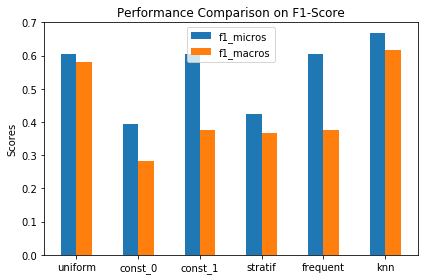

In [15]:
f1_macros, f1_micros, labels = [],[],[]
for clf in predictions:  
    f1_micros.append(f1_score(y_test,predictions[clf],average='micro'))
    f1_macros.append(f1_score(y_test,predictions[clf],average='macro'))
    labels.append(clf)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, f1_macros, width, label='f1_macros')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

#### 3. Discussion

In [16]:
print("The balance of the test set is",round(100*sum(y_test)/len(y_test),1),"% in favor of the alive samples.")

The balance of the test set is 60.6 % in favor of the alive samples.


* Μεταξύ των dummy ταξινομητών, η καλύτερη στρατηγική είναι να διαλέγουμε πάντοτε την πιο συχνή κλάση (frequent) ή ισοδύναμα σταθερά την κλάση που είναι η πιο συχνή (constant-1), μιας και το test set δεν είναι ισορροπημένο, όπως φαίνεται παραπάνω.
* Εαν δοκιμάσουμε πολλά runs, θα παρατηρήσουμε ότι η επιλογή stratified, δηλαδή να επιλέγουμε τυχαία κλάση διατηρώντας την κατανομή των κλάσεων στο training set, ενώ στη γενική περίπτωση δίνει καλύτερα αποτελέσματα από τη random επιλογή, στη προκειμένη, λόγω της ισορροπίας του train dataset, οι δύο μέθοδοι είναι ισοδύναμες. 
* Ο k-NN ταξινομητής δίνει καλύτερο αποτέλεσμα από τους dummy classifiers, αφού βασίζεται σε έναν αλγόριθμο λογικής ανάλυσης των δεδομένων. Παρόλ' αυτά, το dataset παραμένει μικρό και οι εκάστοτε γείτονες δεν είναι αντιπορσωπευτικοί, κάτι που περιορίζει τις δυνατότητες του ταξινομητή.

### D. Optimization of Classifiers

Θα ακολουθήσουμε bottom-up λογική και επιλέγουμε τον classifier που μπορεί να δώσει καλύτερα αποτελέσματα. Εδώ δεν έχουμε παρά να επιλέξουμε τον k-NN classifier, μιας και οι dummy classifiers δεν επηρεάζονται από την εσωτερική επεξεργασία των δεδομένων. Για την εύρεση των βέλτιστων υπερπαραμέτρων θα διατηρήσουμε το διαχωρισμό του dataset σε 80% train και 20% test και θα χρησιμοποιήσουμε 10-fold cross validation για να εκτιμήσουμε τις παραμέτρους μόνο από το train set. Συγκεκριμένα, αφού γίνει η απαραίτητη προεπεξεργασία ολόκληρου του set, αυτό θα χωριστεί σε 10 subsets, καθένα από τα οποία θα δοκιμαστεί σαν validation set. Στη συνέχεια, οι παράμετροι θα δώσουν το καλύτερο cross score θα εφαρμοστούν προκειμένου να κάνουμε το τελικό prediction για το αρχικό μας test set.

#### 1-2. Pre-Processing - Optimization and Execution Time

Μια απλή τεχνική επιλογής χαρακτηριστικών είναι το ελάχιστο κατώφλι της διακύμανσης (Variance threshold). Γενικώς αν η διακύμανση ενός χαρακτηριστικού είναι χαμηλή, δεν μπορεί να προσφέρει σημαντικά στη διαχωριστική ικανότητα του ταξινομητή. Ειδικά στην περίπτωση που η διακύμανση είναι 0, δηλαδή το χαρακτηριστικό εχει σταθερή τιμή για όλα τα δείγματα εκπαίδευσης, δεν χρησιμέυει καθόλου. Χρησιμοποιούμε την συνάρτηση VarianceThreshold() για να αφαιρέσουμε τα χαρακτηριστικά που έχουν πολύ χαμηλή διακύμανση (κάτω από ένα κατώφλι). Πρέπει επίσης να πάρουμε μια μάσκα (index) των χαρακτηριστικών που επιλέγουμε, ώστε να την εφαρμόσουμε και στο test set, ώστε να έχουν τις ίδιες διαστάσεις.

Επίσης, χαρακτηριστικά με πολύ μεγάλες διαφορές στις τιμές τους μπορούν να προκαλέσουν προβλήματα στην εκπαίδευση. Για παράδειγμα ένα χαρακτηριστικό με πολύ μεγάλες τιμές θα έχει μεγαλύτερη επίδραση στον υπολογισμό της απόστασης στον kNN από ότι ένα με μικρές τιμές, χωρίς αυτό να σημαίνει απαραίτητα ότι είναι περισσότερο καθοριστικό. Η κανονικοποίηση μετασχηματίζει τις τιμές των χαρακτηριστικών ώστε να αμβλυνθούν αυτές οι διαφορές και μπορεί να γίνει με 2 τρόπους: Διαιρώντας με τη διαφορά μεγίστου-ελαχίστου (feature scaling) οπότε οι τιμές όλων των χαρακτηριστικών κλιμακώνονται γραμμικά στο διάστημα [0,1] ή με το standard score του κάθε χαρακτηριστικού, που κάνει το χαρακτηριστικό να έχει μέση τιμή μηδέν και διακύμανση μονάδα. H μετατροπή σε standard score είναι απαραίτητη σε πολλούς ταξινομητές για να συμπεριφερθούν σωστά. Επίσης είναι πιο ανθεκτική από την min-max σε σποραδικές τιμές που είναι πολύ μακριά απο τη μέση τιμή και τις υπόλοιπες τιμές του χαρακτηριστικού. Από την άλλη, η κλιμάκωση στο [0,1] είναι λιγότερο ευαίσθητη σε μικρές αποκλίσεις και επίσης σε αραιά διανύσματα διατηρεί τα μηδέν.

Εναλλακτικά της επιλογής χαρακτηριστικών με στόχο τη μείωση της διαστατικότητάς τους, μπορούμε να κάνουμε εξαγωγή νέων χαρακτηριστικών σε ένα χώρο μικρότερων διαστάσεων. Η βασικότερη τεχνική feature extraction είναι η ανάλυση σε κύριες συνιστώσες (PCA) όπου αναλύουμε τα δεδομένα σε κύριες συνιστώσες και δουλέυουμε με τελείως νέες, γραμμικά ασυσχέτιστες μεταβλητές μικρότερης διαστατικότητας.

In [17]:
def applyVarThreshold(data,thres=0):
    selector = VarianceThreshold(threshold=thres)
    return selector.fit_transform(data)

def applyPCA(data,num=len(data[0])):
    pca = PCA(n_components=num)
    return pca.fit_transform(data)

In [18]:
def cross_validation(clf,x_cv,y_cv,cv):
    
    array = []
    fold_len = len(x_cv)//cv
    for fold_num in range(cv): array.append(fold_num*fold_len)
    
    test_acc  = []
    for i in array:
        x_test_temp  = x_cv[i:i+fold_len]
        y_test_temp  = y_cv[i:i+fold_len]
        x_train_temp = np.concatenate((x_cv[:i],x_cv[i+fold_len:]))
        y_train_temp = np.concatenate((y_cv[:i],y_cv[i+fold_len:]))
        clf.fit(x_train_temp,y_train_temp)
        test_acc.append(clf.score(x_test_temp,y_test_temp))
    
    return test_acc


def gridsearch(data,labels,scaler=False,var_thresh=False,pca=False):
    
    accuracies = {}
    
    if scaler == 'MinMax': 
        scaler = preprocessing.MinMaxScaler()
        data   = scaler.fit_transform(data)
    elif scaler == 'Standard': 
        scaler = preprocessing.StandardScaler()
        data   = scaler.fit_transform(data)
    
    for thres in np.arange(0,0.25,0.05):
        data_var = data
        if var_thresh: data_var = applyVarThreshold(data,thres)
                
        for i in range(1,len(data[0])):
            data_pca = data_var
            if pca: data_pca = applyPCA(data_var,i)

            for j in range(1,len(data_pca)//2):
                knn = KNeighborsClassifier(n_neighbors=j) 
                test_score = cross_validation(knn,data_pca,labels,10)
                accuracies[str(i)+"_"+str(thres)+"_"+str(j)] = np.mean(test_score)

            if not pca: break   
        if not var_thresh: break 
    
    k = max(accuracies,key=accuracies.get)
    score = accuracies[k]
    params = k.split("_")
    if var_thresh: print("Best Variance Threshold:",params[1])
    if pca: print("Best PCA Components Number:",params[0])
    print("Best k for k-NN:",params[2])
    print("Score:",round(score,3))
    
    return params

Αρχικά θα εξετάσουμε αν το scaling των δεδομένων θα αυξήσει το accuracy score του k-NN. Θα δοκιμάσουμε τόσο Standard όσο και MinMax scaling:

In [19]:
print("Without Scaling:")
optimal_params = gridsearch(x_train,y_train,scaler=False,var_thresh=False,pca=False)

print("\nWith Standard Scaling:")
optimal_params = gridsearch(x_train,y_train,scaler='Standard',var_thresh=False,pca=False)

print("\nWith MinMax Scaling:")
optimal_params = gridsearch(x_train,y_train,scaler='MinMax',var_thresh=False,pca=False)

Without Scaling:
Best k for k-NN: 7
Score: 0.692

With Standard Scaling:
Best k for k-NN: 10
Score: 0.746

With MinMax Scaling:
Best k for k-NN: 7
Score: 0.754


Συνάγουμε ότι η χρήση scaling βελτιώνει ιδιαιτέρως την επίδοση του ταξινομητή. Από τους δύο scalers καλύτερος είναι ο MinMax ενώ αξίζει να αναφέρουμε ότι οι δύο scalers προτείνουν διαφορετικά βέλτιστα k. Στη συνέχεια, δεδομένου του MinMax scaling, εξετάζουμε την επίδραση του Variance Threshold.  

In [20]:
optimal_params = gridsearch(x_train,y_train,scaler='MinMax',var_thresh=True,pca=False)

Best Variance Threshold: 0.0
Best k for k-NN: 7
Score: 0.754


Συνάγουμε πως το Variance Threshold δεν έχει καμία επίδραση στο τελικό αποτέλεσμα. Όλα τα στοιχεία (τυπικά πλην αυτών που δεν έχουν καμία διακύμανση και είναι άχρηστα) διατηρούνται και το ποσοστό παραμένει αυτό που λάβαμε και προηγουμένως για MinMax scaling. Θα εξετάσουμε τώρα την επίδραση του PCA decomposition:

In [21]:
optimal_params = gridsearch(x_train,y_train,scaler='MinMax',var_thresh=False,pca=True)

Best PCA Components Number: 4
Best k for k-NN: 5
Score: 0.785


Βλέπουμε πως το αποτέλεσμα βελτιώνεται περαιτέρω κατά 3% με την μείωση σε 4 διαστάσεις των δεδομένων μέσω PCA. Παρατηρούμε εδώ και μια αλλαγή στο βέλτιστο αριθμό των κοντινότερων γειτόνων. Τελικώς, από το grid search λαμβάνουμε τις εξής βέλτιστες υπερπαραμέτρους:
* Scaling: **MinMax**
* Variance Threshold: **0.0**
* PCA Decomposition: **4 components**
* Number of nearest neighbors: **5 neighbors**

Επαναλαμβάνουμε τώρα τη διαδικασία ταξινόμησης με τις βελτιστοποιημένες παραμέτρους. Θα κάνουμε νέο τρέξιμο μόνο τον ταξινομητή k-NN αφού οι dummy classifiers δεν επηρεάζονται από τις παραπάνω παραμέτρους. Θα παραθέσουμε πάντως και αυτούς, μαζί με το χρόνο που διαρκεί ο καθένας.

In [22]:
scaler = preprocessing.MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.fit_transform(x_test)

In [29]:
npredictions, nsmall_accuracies, fit_times, pred_times = DummyClassification(x_train_scaled,y_train,x_test_scaled,y_test)

print("Classification Accuracy of Dummy Classifiers for the test set:\n")
for strategy in nsmall_accuracies: print("With",strategy,"strategy:",np.round(100*nsmall_accuracies[strategy],3),"%")

print("\nConfusion Matrices of Dummy Classifiers for the test set:\n")
for strategy in npredictions: print("With",strategy,"strategy:\n",confusion_matrix(y_test,npredictions[strategy]))

for strategy in predictions:
    print("\nClassification Report of",strategy,"strategy:\n",classification_report(y_test,predictions[strategy]))
    
print("\nFit and Predict duration of Dummy Classifiers in secs:\n")
for strategy in npredictions:
    print("Fitting time for",strategy,"strategy:",fit_times[strategy])
    print("Predict time for",strategy,"strategy:",pred_times[strategy],"\n")

Classification Accuracy of Dummy Classifiers for the test set:

With uniform strategy: 42.424 %
With const_0 strategy: 39.394 %
With const_1 strategy: 60.606 %
With stratif strategy: 69.697 %
With frequent strategy: 60.606 %

Confusion Matrices of Dummy Classifiers for the test set:

With uniform strategy:
 [[ 8  5]
 [ 8 12]]
With const_0 strategy:
 [[13  0]
 [20  0]]
With const_1 strategy:
 [[ 0 13]
 [ 0 20]]
With stratif strategy:
 [[ 6  7]
 [ 7 13]]
With frequent strategy:
 [[ 0 13]
 [ 0 20]]

Classification Report of uniform strategy:
               precision    recall  f1-score   support

           0       0.31      0.38      0.34        13
           1       0.53      0.45      0.49        20

    accuracy                           0.42        33
   macro avg       0.42      0.42      0.42        33
weighted avg       0.44      0.42      0.43        33


Classification Report of const_0 strategy:
               precision    recall  f1-score   support

           0       0.39    

In [32]:
x_train_scaled = applyPCA(x_train_scaled,int(optimal_params[0]))
x_test_scaled  = applyPCA(x_test_scaled,int(optimal_params[0]))
knn = KNeighborsClassifier(int(optimal_params[2]))

start_time = time.time()
knn.fit(x_train_scaled,y_train)
fit_times['knn'] = time.time()-start_time

start_time = time.time()
npredictions['knn'] = knn.predict(x_test_scaled)
pred_times['knn'] = time.time()-start_time

nsmall_accuracies['knn'] = knn.score(x_test_scaled,y_test)

print("Classification Accuracy of k-NN for the test set:",np.round(100*nsmall_accuracies['knn'],3),"%")
print("\nConfusion Matrix of k-NN for the test set:\n",confusion_matrix(y_test,npredictions['knn']))
print("\nClassification Report of k-NN for the test set:\n",classification_report(y_test,npredictions['knn']))
print("\nFitting time for k-NN Classifier:",fit_times['knn'])
print("Predict time for k-NN Classifier:",pred_times['knn'])

Classification Accuracy of k-NN for the test set: 57.576 %

Confusion Matrix of k-NN for the test set:
 [[ 4  9]
 [ 5 15]]

Classification Report of k-NN for the test set:
               precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.62      0.75      0.68        20

    accuracy                           0.58        33
   macro avg       0.53      0.53      0.52        33
weighted avg       0.55      0.58      0.56        33


Fitting time for k-NN Classifier: 0.001397848129272461
Predict time for k-NN Classifier: 0.005410909652709961


Παρατηρούμε πως η απόδοση χειροτερεύει εφαρμόζοντας τις παραμέτρους που βρήκαμε στο grid search. Αυτό μπορεί να οφείλεται αποκλειστικά στο μικρό μέγεθος του dataset. Τα δεδομένα μας δεν είναι αρκετά αντιπροσωπευτικά, ώστε να διατηρούν ίδιες ιδιότητες κατά το split σε train, validation και test sets.

#### 3. Bar Plots

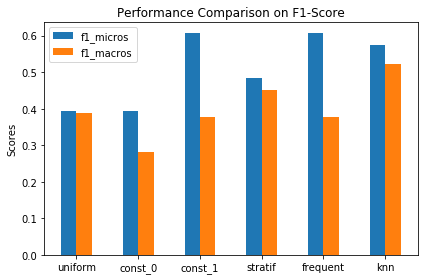

In [25]:
f1_macros, f1_micros, labels = [],[],[]
for clf in npredictions:  
    f1_micros.append(f1_score(y_test,npredictions[clf],average='micro'))
    f1_macros.append(f1_score(y_test,npredictions[clf],average='macro'))
    labels.append(clf)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, f1_macros, width, label='f1_macros')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

#### 4. Optimization Table

In [26]:
nsmall_accuracies['knn']=nsmall_accuracies['knn']
for clf in small_accuracies:
    print("Improvement for",clf,":",np.round(nsmall_accuracies[clf]-small_accuracies[clf],3))

Improvement for uniform : 0.0
Improvement for const_0 : 0.0
Improvement for const_1 : 0.0
Improvement for stratif : -0.061
Improvement for frequent : 0.0
Improvement for knn : -0.091


#### 5. Discussion

Όπως περιγράψαμε παραπάνω, ακολουθήσαμε μια bottom-up λογική για να επιλέξουμε τις βέλτιστες υπερπαραμέτρους pre-processing και training του dataset, ούτως ώστε να αυξήσουμε το accuracy της ταξινόμησης. Ενώ είδαμε βελτίωση με τη μέθοδο του cross validation, η μη αντιπροσωπευτικότητα των επιμέρους sets δεν επέτρεψε την αύξηση του score στο test set, το αντίθετο μάλιστα. Από κει και πέρα, οι παρατηρήσεις που έγιναν στο (C) για τους dummy classifiers συνεχίζουν να ισχύουν καθώς αυτοί δεν επηρεάζονται από το tuning. Όσον αφορά τους χρόνους εκτέλεσης, αξίζει να παρατηρήσουμε ότι το fit παίρνει περισσότερο χρόνο από το prediction. Τα παραπάνω συμπεράσματα φαίνονται και στο Optimization Table παραπάνω.